# Classifying Galaxy Mergers with Aggregated Attention

- Improve the CNN model using attention for merger-classification
- Edit some codes to resolve `tensorflow` version issues, currently compatible with `2.6.x`. They changed too many for each update.

## Setup and Imports

This example requires TensorFlow Addons, which can be installed using
the following command:

```shell
pip install -U tensorflow-addons
```

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [2]:
## version check

print(tf.__version__)

2.6.2


In [3]:
# Set seed for reproducibiltiy
SEED = 42
tf.random.set_seed(SEED)

## Hyperparameters

In [4]:
# DATA
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10  # for CIFAR 10

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.

# ARCHITECTURE
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

## Load the CIFAR10 dataset

#### Download train sample 

- I use `markdown` to disable the entire block

```
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")
```

#### Save the train sample for later uses 

In [5]:
!pwd

/tf/work/cnn


```
import pickle

with open("cifar10.pkl", "wb") as f:
    pickle.dump([x_train,x_val,x_test,y_train,y_val,y_test], f)
```

#### Load the data from disk 

In [6]:
!ls

cifar10.pkl		  hong_patch_conv_net_test_commentary_v1.ipynb
hello-keras-new-tf.ipynb  patch_conv_net.ipynb
hello-keras.ipynb


In [7]:
import pickle

with open("cifar10.pkl", "rb") as f:
    x_train,x_val,x_test,y_train,y_val,y_test = pickle.load(f)

## Explore the CIFAR10 dataset

In [8]:
x_train.shape

(40000, 32, 32, 3)

In [9]:
y_train.shape

(40000, 1)

In [10]:
y_train[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

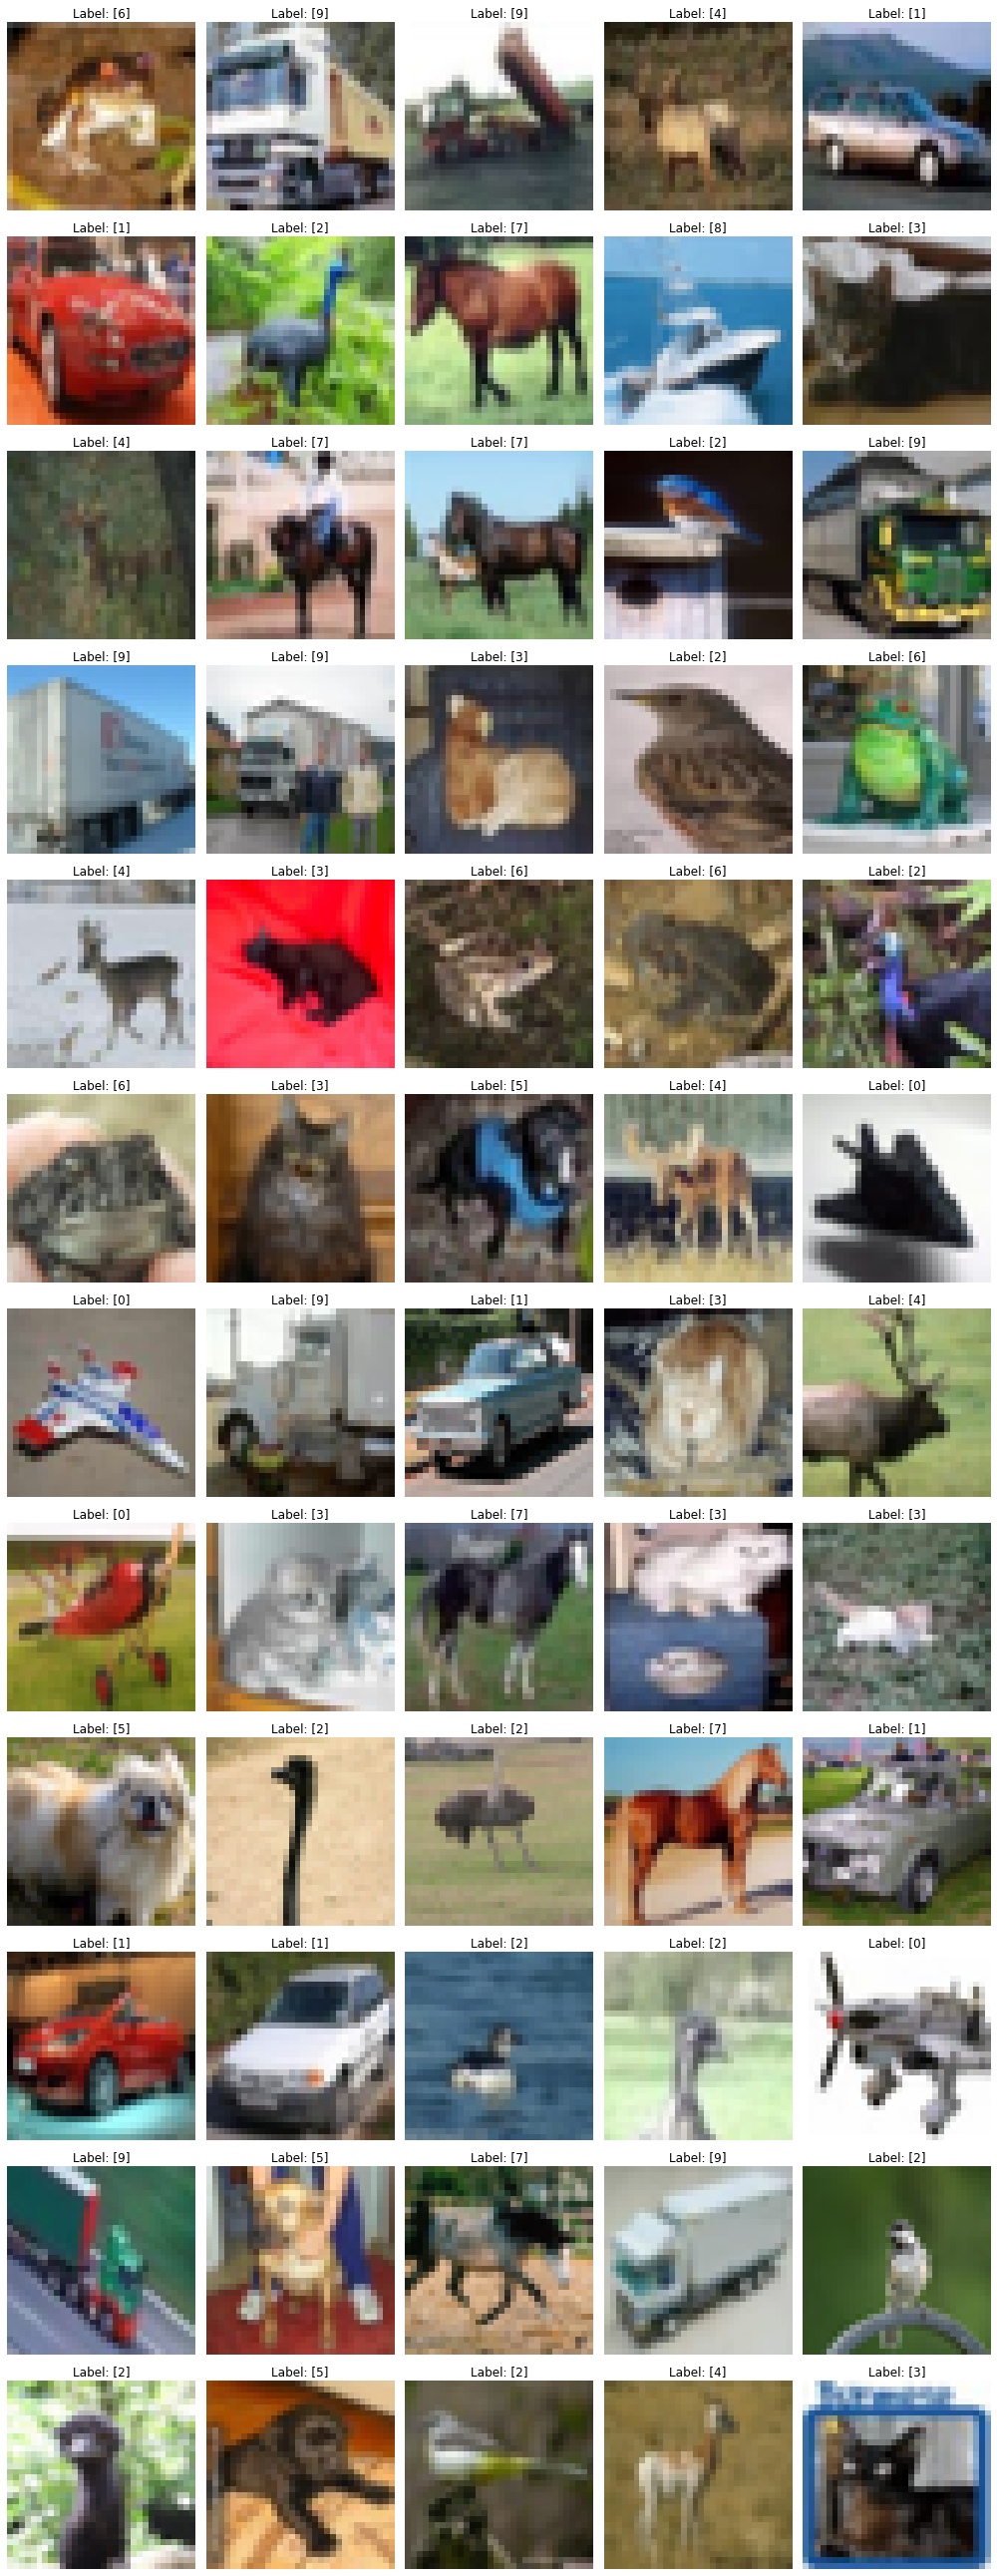

In [11]:
fig=plt.figure(figsize=(14, 36))
for i in range(60):
    ax=plt.subplot(12, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title('Label: '+str(y_train[i]))
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

#### Prefetch Datasets 

- The `PrefetchDataset` in TensorFlow is a dataset that asynchronously prefetches elements from another dataset. This can be used to improve the performance of machine learning models by reducing the amount of time spent waiting for data.

- The `PrefetchDataset` takes two arguments: the input dataset and the number of elements to prefetch. The number of elements to prefetch should be a positive integer.

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

## [1] Basic Layers 

### Augmentation layers

- Recall: <br>
`
INPUT_SHAPE = (32, 32, 3)
IMAGE_SIZE = 48
` 

In [13]:
def get_preprocessing():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="preprocessing",
    )
    return model


def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


- The `Rescaling` layer is used to normalize the input data to a range of 0 to 1. This is done by dividing the input data by 255.0, which is the maximum value of an RGB pixel.

- The `Resizing` layer is used to resize the input data to a specific size. In this case, the input data is resized to a size of `INPUT_SHAPE[0] + 20 x INPUT_SHAPE[0] + 20`. This is done to give the CNN more flexibility when learning the features of the data.

- The `RandomCrop` layer is used to randomly crop the input data to a specific size. In this case, the input data is cropped to a size of `IMAGE_SIZE x IMAGE_SIZE`. This is done to help the CNN learn to generalize to different variations of the data.

- The `RandomFlip` layer is used to randomly flip the input data horizontally. This is done to help the CNN learn to be invariant to changes in the orientation of the data.



### Convolutional stem

The stem of the model is a lightweight preprocessing module that
maps images pixels to a set of vectors (patches).

- Recall: <br>
`
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2
`

In [14]:
def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem


> The **dictionary** `config` has four `keys`: `kernel_size, strides, activation,` and `padding`.

## [2] Core Steps

### Convolutional trunk

The trunk of the model is the most compute-intesive part. It consists
of `N` stacked residual convolutional blocks.

In [15]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

The class `SqueezeExcite` is a popular attention mechanism that can be used to improve the performance of convolutional neural networks (CNNs).

The SqueezeExcite layer takes two arguments: the `ratio` and the `**kwargs`. The `ratio` argument is a float that specifies the ratio with which the feature map needs to be reduced in the reduction phase. The `**kwargs` argument is a dictionary of keyword arguments that can be used to customize the layer.

The SqueezeExcite layer has four steps:

- The **squeeze** layer performs global average pooling on the input feature maps. This reduces the feature maps to a single vector.
- The **reduction** layer applies a dense layer with a ReLU activation function to the output of the squeeze layer. This reduces the size of the vector.
- The **excite** layer applies a dense layer with a sigmoid activation function to the output of the reduction layer. This produces a vector of weights.
- The **multiply** layer multiplies the output of the squeeze layer by the output of the excite layer. This produces the output of the SqueezeExcite layer.

In [16]:
class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692

    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio

    Inputs:
        Convolutional features extracted from the conv stem.

    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {"ratio": self.ratio, "dimensions": self.dimensions, "depth": self.depth,}
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": tf.nn.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        return x

The **Trunk layer** has five steps:

- The `LayerNormalization` layer normalizes the input feature maps. This helps to improve the stability of the training process.
- The `Conv2D` layer applies a convolutional layer with the specified number of filters and activation function to the normalized feature maps.
- The `Conv2D` layer applies another convolutional layer with the specified number of filters and activation function to the output of the first convolutional layer.
- The `SqueezeExcite` layer applies the SqueezeExcite attention mechanism to the output of the second convolutional layer.
- The `Conv2D` layer applies a final convolutional layer with the specified number of filters to the output of the SqueezeExcite layer.

### Attention Pooling

The output of the convolutional trunk is attended with a trainable
_query_ class token. The resulting attention map is the weight of
every patch of the image for a classification decision.

In [17]:
class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the
    trunk with the CLS token.

    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.

    Inputs:
        Flattened patches from the trunk.

    Outputs:
        The modifies CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = tf.Variable(tf.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1, key_dim=self.dimensions, dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
            ]
        )
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Expand the class token batch number of times.
        class_token = tf.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = tf.concat([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        # Build the logits
        logits = self.dense(class_token)
        return logits, tf.squeeze(viz_weights)[..., 1:]


The `AttentionPooling` layer is a class in Keras that can be used to apply attention to the patches extracted from the trunk with the `CLS` token.

The `AttentionPooling` layer takes two arguments: the `dimensions` and the `num_classes`. The dimensions argument is an integer that specifies the number of features in the input data. The num_classes argument is an integer that specifies the number of classes in the dataset.

The `AttentionPooling` layer has six steps:

- The `cls` variable is initialized to a tensor of zeros with the shape `(1, 1, dimensions)`. This tensor will be used as the `CLS` token.
- The `attention` layer applies `multi-head attention` to the input data. This layer takes three inputs: the query, the key, and the value. The query is the CLS token. The key and the value are the flattened patches extracted from the trunk.
- The `layer_norm1` layer normalizes the output of the attention layer. This helps to improve the stability of the training process.
- The `viz_weights` tensor is the attention weights. It can be used to visualize how the attention layer is attending to the different patches.
- The `class_token` tensor is the output of the attention layer. It is a weighted sum of the flattened patches extracted from the trunk.
- The `class_token` tensor is passed through a series of dense layers to produce the logits. The logits are the predictions for the classes.

#### FYI: Multi-head attention and CLS token 

**Multi-head attention** is a technique that allows the model to attend to different parts of the input sequence in different ways. This is done by dividing the input sequence into multiple heads, and then attending to each head separately. The output of the attention layer is then a weighted sum of the outputs of the different heads.

**CLS token (Classification token)** is a special token that is added to the beginning of the input sequence and is used to represent the overall class of the input. The CLS token is used in attention-based models because it allows the model to learn the relationship between the different parts of the input sequence and the overall class of the input.

**How do they work together?**

Multi-head attention and CLS token can be used together to improve the performance of attention-based deep learning models. The CLS token is used to represent the overall class of the input sequence, and the multi-head attention layer is used to attend to different parts of the input sequence in different ways. This allows the model to learn the relationship between the different parts of the input sequence and the overall class of the input.

For example, in a text classification task, the **CLS token** could be used to represent the **overall sentiment** of the text. The **multi-head attention** layer could then be used to attend to different parts of the text, such as the **individual words, the phrases, and the sentences**. This would allow the model to learn how the different parts of the text contribute to the overall sentiment of the text.





## [3] Wrap up: Patch Convnet 

The patch-convnet is shown in the figure below.

| ![image model](https://i.imgur.com/NHiQeac.png) |
| :--: |
| [Source](https://arxiv.org/abs/2112.13692) |

All the modules in the architecture are built in the earlier seciton.
In this section, we stack all of the different modules together.

In [18]:
class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        preprocessing_model,
        train_augmentation_model,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                "train_augmentation_model": self.train_augmentation_model,
                "preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        augmented_images = self.preprocessing_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights


## Callbacks

This callback will plot the image and the attention map overlayed on
the image.

In [19]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_labels = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            test_augmented_images = self.model.preprocessing_model(test_images)
            # Pass through the stem.
            test_x = self.model.stem(test_augmented_images)
            # Pass through the trunk.
            test_x = self.model.trunk(test_x)
            # Pass through the attention pooling block.
            _, test_viz_weights = self.model.attention_pooling(test_x)
            # Reshape the vizualization weights
            num_patches = tf.shape(test_viz_weights)[-1]
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            # Take a random image and its attention weights.
            index = np.random.randint(low=0, high=tf.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            # Plot the images and the overlayed attention map.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(
                selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent()
            )
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()


## Learning rate schedule

In [20]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

## Training

We build the model, compile it, and train it.

Epoch 1/50
313/313 [==============================] - 15s 34ms/step - loss: 1.9648 - accuracy: 0.2619 - top-5-accuracy: 0.7793 - val_loss: 1.8228 - val_accuracy: 0.3481 - val_top-5-accuracy: 0.8235
Epoch 2/50
313/313 [==============================] - 10s 33ms/step - loss: 1.5462 - accuracy: 0.4226 - top-5-accuracy: 0.9099 - val_loss: 1.4502 - val_accuracy: 0.4495 - val_top-5-accuracy: 0.9301
Epoch 3/50
313/313 [==============================] - 10s 33ms/step - loss: 1.3298 - accuracy: 0.5118 - top-5-accuracy: 0.9381 - val_loss: 1.2334 - val_accuracy: 0.5568 - val_top-5-accuracy: 0.9507
Epoch 4/50
313/313 [==============================] - 10s 33ms/step - loss: 1.1604 - accuracy: 0.5820 - top-5-accuracy: 0.9546 - val_loss: 1.1229 - val_accuracy: 0.6044 - val_top-5-accuracy: 0.9501
Epoch 5/50
313/313 [==============================] - 10s 33ms/step - loss: 1.0337 - accuracy: 0.6300 - top-5-accuracy: 0.9648 - val_loss: 0.9657 - val_accuracy: 0.6549 - val_top-5-accuracy: 0.9712


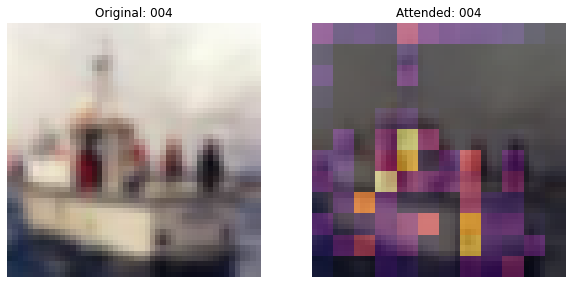

Epoch 6/50
313/313 [==============================] - 10s 33ms/step - loss: 0.9231 - accuracy: 0.6726 - top-5-accuracy: 0.9732 - val_loss: 0.9187 - val_accuracy: 0.6745 - val_top-5-accuracy: 0.9735
Epoch 7/50
313/313 [==============================] - 10s 33ms/step - loss: 0.8276 - accuracy: 0.7067 - top-5-accuracy: 0.9781 - val_loss: 0.9101 - val_accuracy: 0.6933 - val_top-5-accuracy: 0.9732
Epoch 8/50
313/313 [==============================] - 10s 33ms/step - loss: 0.7635 - accuracy: 0.7316 - top-5-accuracy: 0.9828 - val_loss: 0.8190 - val_accuracy: 0.7132 - val_top-5-accuracy: 0.9780
Epoch 9/50
313/313 [==============================] - 10s 33ms/step - loss: 0.6826 - accuracy: 0.7615 - top-5-accuracy: 0.9853 - val_loss: 0.6906 - val_accuracy: 0.7592 - val_top-5-accuracy: 0.9837
Epoch 10/50
313/313 [==============================] - 10s 33ms/step - loss: 0.6261 - accuracy: 0.7809 - top-5-accuracy: 0.9884 - val_loss: 0.7397 - val_accuracy: 0.7532 - val_top-5-accuracy: 0.9845


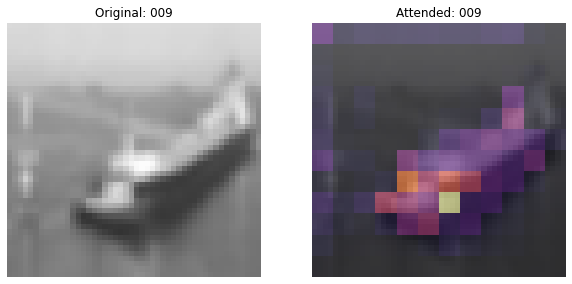

Epoch 11/50
313/313 [==============================] - 10s 33ms/step - loss: 0.5846 - accuracy: 0.7969 - top-5-accuracy: 0.9894 - val_loss: 0.6946 - val_accuracy: 0.7624 - val_top-5-accuracy: 0.9856
Epoch 12/50
313/313 [==============================] - 10s 33ms/step - loss: 0.5613 - accuracy: 0.8055 - top-5-accuracy: 0.9909 - val_loss: 0.6543 - val_accuracy: 0.7836 - val_top-5-accuracy: 0.9841
Epoch 13/50
313/313 [==============================] - 10s 33ms/step - loss: 0.5381 - accuracy: 0.8130 - top-5-accuracy: 0.9914 - val_loss: 0.6280 - val_accuracy: 0.7867 - val_top-5-accuracy: 0.9843
Epoch 14/50
313/313 [==============================] - 10s 33ms/step - loss: 0.4976 - accuracy: 0.8266 - top-5-accuracy: 0.9928 - val_loss: 0.5839 - val_accuracy: 0.8015 - val_top-5-accuracy: 0.9877
Epoch 15/50
313/313 [==============================] - 11s 34ms/step - loss: 0.4768 - accuracy: 0.8343 - top-5-accuracy: 0.9934 - val_loss: 0.5900 - val_accuracy: 0.8052 - val_top-5-accuracy: 0.9880


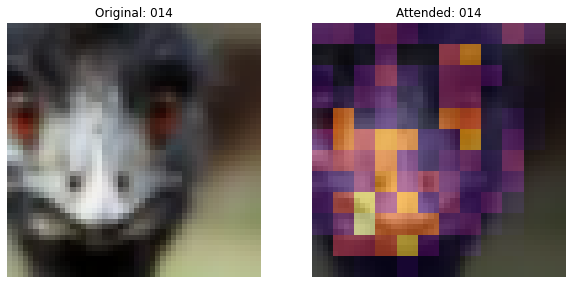

Epoch 16/50
313/313 [==============================] - 11s 34ms/step - loss: 0.4663 - accuracy: 0.8385 - top-5-accuracy: 0.9938 - val_loss: 0.5479 - val_accuracy: 0.8133 - val_top-5-accuracy: 0.9891
Epoch 17/50
313/313 [==============================] - 11s 34ms/step - loss: 0.4412 - accuracy: 0.8481 - top-5-accuracy: 0.9938 - val_loss: 0.6008 - val_accuracy: 0.7939 - val_top-5-accuracy: 0.9882
Epoch 18/50
313/313 [==============================] - 11s 34ms/step - loss: 0.4206 - accuracy: 0.8539 - top-5-accuracy: 0.9953 - val_loss: 0.5596 - val_accuracy: 0.8143 - val_top-5-accuracy: 0.9883
Epoch 19/50
313/313 [==============================] - 11s 34ms/step - loss: 0.4010 - accuracy: 0.8599 - top-5-accuracy: 0.9955 - val_loss: 0.5462 - val_accuracy: 0.8084 - val_top-5-accuracy: 0.9904
Epoch 20/50
313/313 [==============================] - 11s 34ms/step - loss: 0.3870 - accuracy: 0.8660 - top-5-accuracy: 0.9959 - val_loss: 0.5181 - val_accuracy: 0.8222 - val_top-5-accuracy: 0.9905


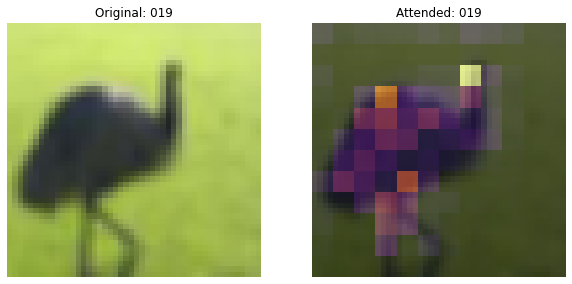

Epoch 21/50
313/313 [==============================] - 11s 34ms/step - loss: 0.3651 - accuracy: 0.8748 - top-5-accuracy: 0.9964 - val_loss: 0.5251 - val_accuracy: 0.8279 - val_top-5-accuracy: 0.9890
Epoch 22/50
313/313 [==============================] - 11s 34ms/step - loss: 0.3473 - accuracy: 0.8779 - top-5-accuracy: 0.9965 - val_loss: 0.5199 - val_accuracy: 0.8303 - val_top-5-accuracy: 0.9920
Epoch 23/50
313/313 [==============================] - 11s 34ms/step - loss: 0.3402 - accuracy: 0.8813 - top-5-accuracy: 0.9969 - val_loss: 0.5197 - val_accuracy: 0.8287 - val_top-5-accuracy: 0.9909
Epoch 24/50
313/313 [==============================] - 11s 34ms/step - loss: 0.3179 - accuracy: 0.8903 - top-5-accuracy: 0.9973 - val_loss: 0.4939 - val_accuracy: 0.8369 - val_top-5-accuracy: 0.9907
Epoch 25/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2943 - accuracy: 0.8989 - top-5-accuracy: 0.9973 - val_loss: 0.5220 - val_accuracy: 0.8290 - val_top-5-accuracy: 0.9926


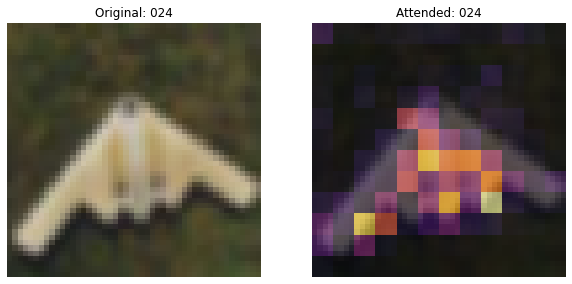

Epoch 26/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2844 - accuracy: 0.9007 - top-5-accuracy: 0.9978 - val_loss: 0.5093 - val_accuracy: 0.8356 - val_top-5-accuracy: 0.9905
Epoch 27/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2769 - accuracy: 0.9044 - top-5-accuracy: 0.9980 - val_loss: 0.5130 - val_accuracy: 0.8376 - val_top-5-accuracy: 0.9923
Epoch 28/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2586 - accuracy: 0.9090 - top-5-accuracy: 0.9986 - val_loss: 0.4923 - val_accuracy: 0.8396 - val_top-5-accuracy: 0.9932
Epoch 29/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2334 - accuracy: 0.9194 - top-5-accuracy: 0.9984 - val_loss: 0.4870 - val_accuracy: 0.8478 - val_top-5-accuracy: 0.9919
Epoch 30/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2199 - accuracy: 0.9236 - top-5-accuracy: 0.9988 - val_loss: 0.4933 - val_accuracy: 0.8433 - val_top-5-accuracy: 0.9915


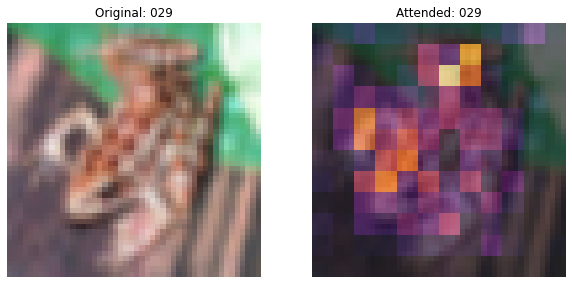

Epoch 31/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2121 - accuracy: 0.9276 - top-5-accuracy: 0.9990 - val_loss: 0.4990 - val_accuracy: 0.8469 - val_top-5-accuracy: 0.9933
Epoch 32/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1888 - accuracy: 0.9336 - top-5-accuracy: 0.9992 - val_loss: 0.5340 - val_accuracy: 0.8469 - val_top-5-accuracy: 0.9933
Epoch 33/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1810 - accuracy: 0.9375 - top-5-accuracy: 0.9994 - val_loss: 0.5138 - val_accuracy: 0.8530 - val_top-5-accuracy: 0.9913
Epoch 34/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1624 - accuracy: 0.9435 - top-5-accuracy: 0.9995 - val_loss: 0.5427 - val_accuracy: 0.8485 - val_top-5-accuracy: 0.9906
Epoch 35/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1499 - accuracy: 0.9480 - top-5-accuracy: 0.9995 - val_loss: 0.4948 - val_accuracy: 0.8565 - val_top-5-accuracy: 0.9923


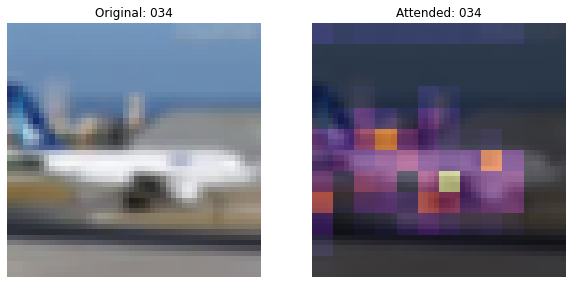

Epoch 36/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1378 - accuracy: 0.9531 - top-5-accuracy: 0.9995 - val_loss: 0.5200 - val_accuracy: 0.8581 - val_top-5-accuracy: 0.9933
Epoch 37/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1358 - accuracy: 0.9543 - top-5-accuracy: 0.9997 - val_loss: 0.5092 - val_accuracy: 0.8569 - val_top-5-accuracy: 0.9926
Epoch 38/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1189 - accuracy: 0.9592 - top-5-accuracy: 0.9997 - val_loss: 0.4847 - val_accuracy: 0.8671 - val_top-5-accuracy: 0.9936
Epoch 39/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1104 - accuracy: 0.9622 - top-5-accuracy: 0.9997 - val_loss: 0.5137 - val_accuracy: 0.8578 - val_top-5-accuracy: 0.9920
Epoch 40/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0972 - accuracy: 0.9681 - top-5-accuracy: 0.9998 - val_loss: 0.5158 - val_accuracy: 0.8599 - val_top-5-accuracy: 0.9921


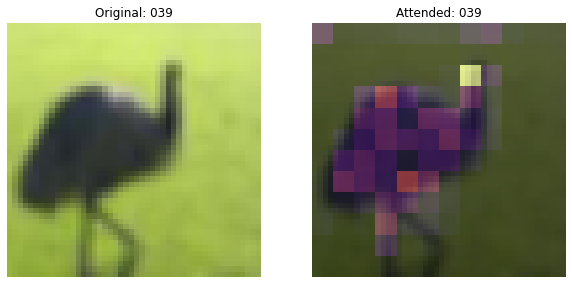

Epoch 41/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0937 - accuracy: 0.9677 - top-5-accuracy: 0.9999 - val_loss: 0.5469 - val_accuracy: 0.8582 - val_top-5-accuracy: 0.9919
Epoch 42/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0899 - accuracy: 0.9700 - top-5-accuracy: 0.9999 - val_loss: 0.5183 - val_accuracy: 0.8616 - val_top-5-accuracy: 0.9915
Epoch 43/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0790 - accuracy: 0.9738 - top-5-accuracy: 0.9999 - val_loss: 0.5224 - val_accuracy: 0.8623 - val_top-5-accuracy: 0.9921
Epoch 44/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0802 - accuracy: 0.9734 - top-5-accuracy: 0.9999 - val_loss: 0.4853 - val_accuracy: 0.8666 - val_top-5-accuracy: 0.9927
Epoch 45/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0784 - accuracy: 0.9746 - top-5-accuracy: 0.9998 - val_loss: 0.4838 - val_accuracy: 0.8661 - val_top-5-accuracy: 0.9927


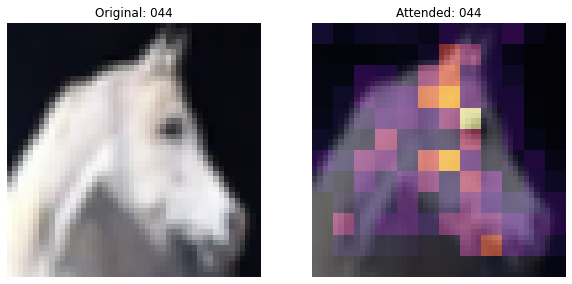

Epoch 46/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0817 - accuracy: 0.9744 - top-5-accuracy: 0.9999 - val_loss: 0.4815 - val_accuracy: 0.8648 - val_top-5-accuracy: 0.9918
Epoch 47/50
313/313 [==============================] - 11s 34ms/step - loss: 0.0906 - accuracy: 0.9707 - top-5-accuracy: 0.9999 - val_loss: 0.4500 - val_accuracy: 0.8682 - val_top-5-accuracy: 0.9923
Epoch 48/50
313/313 [==============================] - 11s 35ms/step - loss: 0.1052 - accuracy: 0.9682 - top-5-accuracy: 0.9998 - val_loss: 0.4410 - val_accuracy: 0.8650 - val_top-5-accuracy: 0.9921
Epoch 49/50
313/313 [==============================] - 11s 35ms/step - loss: 0.1310 - accuracy: 0.9595 - top-5-accuracy: 0.9998 - val_loss: 0.4380 - val_accuracy: 0.8607 - val_top-5-accuracy: 0.9915
Epoch 50/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1809 - accuracy: 0.9461 - top-5-accuracy: 0.9995 - val_loss: 0.4642 - val_accuracy: 0.8493 - val_top-5-accuracy: 0.9905


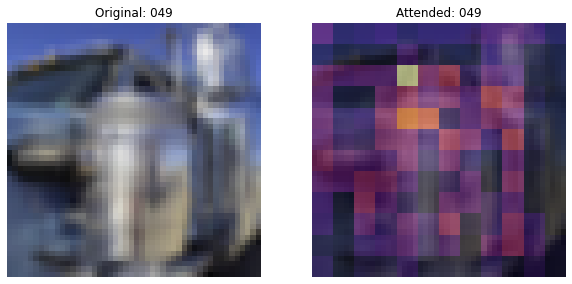

79/79 [==============================] - 1s 11ms/step - loss: 0.4677 - accuracy: 0.8440 - top-5-accuracy: 0.9924
Loss: 0.47
Top 1 test accuracy: 84.40%
Top 5 test accuracy: 99.24%
CPU times: user 7min 56s, sys: 2min 3s, total: 9min 59s
Wall time: 8min 58s


In [21]:
%%time

train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)

patch_conv_net = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    train_augmentation_model=train_augmentation_model,
    preprocessing_model=preprocessing_model,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]
# Get the optimizer.
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
# Compile and pretrain the model.
patch_conv_net.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = patch_conv_net.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Evaluate the model with the test dataset.
loss, acc_top1, acc_top5 = patch_conv_net.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1*100:0.2f}%")
print(f"Top 5 test accuracy: {acc_top5*100:0.2f}%")

## Inference

Here, we use the trained model to plot the attention map.

In [22]:
def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    image = tf.image.resize(image, (32, 32))
    image = image[tf.newaxis, ...]
    test_augmented_images = patch_conv_net.preprocessing_model(image)
    # Pass through the stem.
    test_x = patch_conv_net.stem(test_augmented_images)
    # Pass through the trunk.
    test_x = patch_conv_net.trunk(test_x)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_conv_net.attention_pooling(test_x)
    test_viz_weights = test_viz_weights[tf.newaxis, ...]
    # Reshape the vizualization weights.
    num_patches = tf.shape(test_viz_weights)[-1]
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    selected_image = test_augmented_images[0]
    selected_weight = test_viz_weights[0]
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


#url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
#image_name = keras.utils.get_file(fname="image.jpg", origin=url)
#image = tf.io.read_file(image_name)
#image = tf.io.decode_image(image)
#plot_attention(image)

# Original Notebook Information

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2022/01/22<br>
**Last modified:** 2022/01/22<br>
**Description:** Building a patch-convnet architecture and visualizing its attention maps.

Vision transformers ([Dosovitskiy et. al](https://arxiv.org/abs/2010.11929))
have emerged as a powerful alternative to Convolutional Neural Networks.
ViTs process the images in a patch-based manner. The image information
is then aggregated into a `CLASS` token. This token correlates to the
most important patches of the image for a particular classification decision.

The interaction between the `CLASS` token and the patches can be visualized
to help explain a classification decision. In the academic paper
[Augmenting convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692)
by Touvron et. al, the authors propose to set up an equivalent visualization for
convnets. They propose to substitute the global average pooling layer
of a convnet with a Transformer layer. The self-attention layer of the
Transformer would produces attention maps that correspond to the
most attended patches of the image for the classification decision.

In this example, we minimally implement the ideas of
[Augmenting Convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692).
The main goal of this example is to cover the following ideas, with
minor modifications (to adjust the implementation with CIFAR10):

- The simple design for the attention-based pooling layer, such that
    it explicitly provides the weights (importance) of the different
    patches.
- The novel architecture of convnet called the **PatchConvNet** which
    deviates from the age old pyramidal architecture.
    
    
### Conclusions

The attention map corresponding to the trainable `CLASS`
token and the patches of the image helps explain the classificaiton
decision. One should also note that the attention maps gradually get
better. In the initial training regime, the attention is scattered all
around while at a later stage, it focuses more on the objects of the
image.

The non-pyramidal convnet achieves an accuracy of ~84-85% top-1 test
accuracy.

I would like to thank [JarvisLabs.ai](https://jarvislabs.ai/) for
providing GPU credits for this project.

You can try the model on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/patch-conv-net).